<h2>Simulacion Python</h2>

In [2]:
import numpy as np
from scipy import signal as signal
from pytc2.sistemas_lineales import analyze_sys, pretty_print_bicuad_omegayq,tfcascade,pretty_print_lti


#parametros del filtro a diseñar

fp1 = 19.90972 * 10**3
fp2 = 24.30952 * 10**3
fs1 = 17 * 10**3
fs2 = 36 * 10**3

Calculo los parametros de la plantilla Low pass 

In [66]:
#calculo norma de frecuencia y la aplico a los valores del filtro
norma_w = np.sqrt(fp1*fp2)

wp1_n = fp1 / norma_w 
wp2_n = fp2 / norma_w
ws1_n = fs1 / norma_w
ws2_n = fs2 / norma_w

print(f"Wp1_n={wp1_n};Wp2_n={wp2_n}")
print(f"Ws1_n={ws1_n};Ws2_n={ws2_n}")
BW = wp2_n - wp1_n
Q = 1/BW

# valores de omega con nucleo de transformacion (para plantilla de pasa bajos)
omega_s1=  Q * (ws1_n**2 - 1)/ws1_n
omega_s2=  Q * (ws2_n**2 - 1)/ws2_n
omega_p1=  Q * (wp1_n**2 - 1)/wp1_n
omega_p2=  Q * (wp2_n**2 - 1)/wp2_n

# elijo los valores mas exigentes para el filtro (valor mas chico en modulo)

omega_s = np.abs( omega_s1)
omega_p = omega_p2

#obtengo los valores de epsilon y n del filtro pasabajos

alpha_max = 0.5
alpha_min = 16

epsilon = np.sqrt((10**(alpha_max/10)) - 1) 
print("Calculo del N del filtro:")

for n in range(1,5): # veo que numero de N se necesita para la plantilla del PB
    alpha_min_c = 10 * np.log10(1+ epsilon**2 * np.cosh(n * np.arccosh(omega_s))**2 )
    print(f"alpha_min={alpha_min_c} para un n={n}")
    if alpha_min < alpha_min_c:
       alpha_min = alpha_min_c 
       n=3
       break
    n=0
print(f"Filtro de orden N={n} con un epsilon={epsilon}")

Wp1_n=0.9049912586855338;Wp2_n=1.1049830486235446
Ws1_n=0.7727306761548668;Ws2_n=1.6363708436220707
Calculo del N del filtro:
alpha_min=2.6228510302891723 para un n=1
alpha_min=13.085696819329051 para un n=2
alpha_min=26.86737148112998 para un n=3
Filtro de orden N=3 con un epsilon=0.34931140018894796


Con los valores obtenidos previamente se calcula la transferencia modulo cuadrado low pass de un chebby, y con la transferencia obtenida se obtienen sus raices para obtener la transferencia del sistema

In [14]:

# Obtengo raices de la transferencia pasa bajos al cuadrado

roots = np.roots([-1, 0,-1.5,0,-0.5625,0,0.5122])

print(f"Raices Transferencia pasa bajos modulo cuadrado: {roots}")

# De estas raices debo tomar aquellas que esten en el semiplano izquierdo (parte real negativa)
# Con esto construyo transferencia pasa bajos

denominador = np.poly([-0.31322505+1.02192456j,-0.31322505-1.02192456j,-0.62645011])
numerador = [0.7157]

print(f"\n\nTransferencia obtenida:")
pretty_print_lti(numerador,denominador)

# Aplico el nucleo de transformacion a la transferencia previa
# Finalmente obtengo los coeficientes del numerador y denominador

Raices Transferencia pasa bajos modulo cuadrado: [-0.31322505+1.02192456j -0.31322505-1.02192456j  0.31322505+1.02192456j
  0.31322505-1.02192456j -0.62645011+0.j          0.62645011+0.j        ]


Transferencia obtenida:


<IPython.core.display.Math object>

A continuacion compruebo que este valor de transferencia obtenido coincide con el esperado utilizando las funciones incorporadas en numpy.

In [13]:
atenuacion_deseada = 0.5  # Atenuación deseada en la banda de paso (en decibeles)
wp = 1 # Frecuencia de corte del filtro (en hertz)
N = 3

numerador, denominador = signal.cheby1(N, atenuacion_deseada, wp, btype='low', analog=True, output='ba')
pretty_print_lti(numerador,denominador)

<IPython.core.display.Math object>

Aplico nucleo de transformacion y con ello obtengo una transferencia que sera el filtro pasa bandas de orden 3 tipo chebby

In [15]:
# coeficientes calculados en forma algebraica a partir del nucleo de transformacion:

numerador = [0.0057248,0,0,0]
denominador = [1,0.25058,3.061,0.5068,3.061,0.25058,1]

pretty_print_lti(numerador,denominador)


<IPython.core.display.Math object>

Para comprobar si el paso anterior es correcto podemos calcular nuevamente el filtro mediante funciones integradas en numpy y comprobar si los coeficientes coinciden


In [23]:
atenuacion_banda_paso = 0.5  # Atenuación deseada en la banda de paso (en decibeles)
rizo_bp = 1 # Frecuencia de corte del filtro (en hertz)
order = 3
wp= [0.9049912586855338,1.1049830486235446]

numerador, denominador = signal.cheby1(order,atenuacion_banda_paso,wp, btype='band', analog=True, output='ba')
pretty_print_lti(numerador,denominador)

<IPython.core.display.Math object>

Una vez obtenida la transferencia podemos graficar la respuesta del filtro:

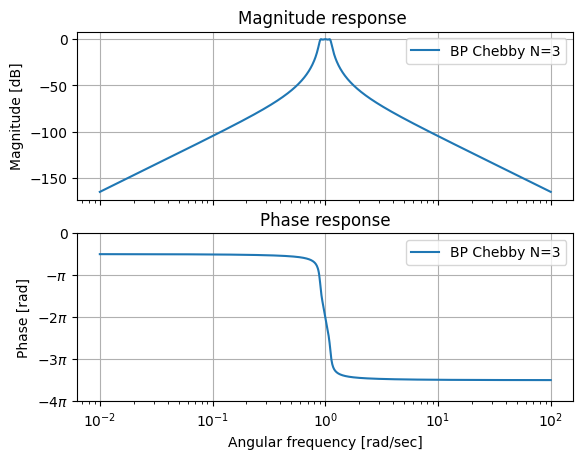

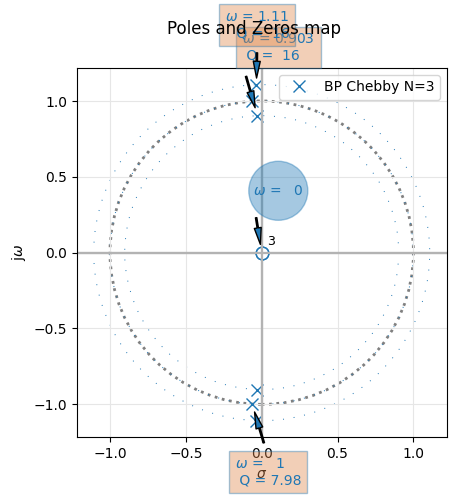

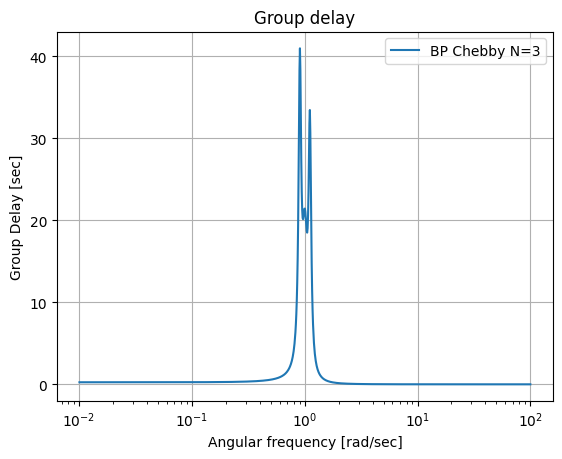

In [24]:
num = np.array(numerador)
den = np.array(denominador)
H1 = signal.TransferFunction( num, den )

analyze_sys(H1,"BP Chebby N=3",same_figs=False)


Para poder implementar el circuito es necesario obtener la transferencia en varios polinomios de primer o segundo orden, para ello calculamos las raices de la transferencia obtenida y con esos polos obtenemos las diferentes transferencias.


In [26]:
roots_pb = np.roots(denominador)
print(f"Las raices son: {roots_pb}")

Las raices son: [-0.03450719+1.1069132j  -0.03450719-1.1069132j  -0.06264308+0.99803599j
 -0.06264308-0.99803599j -0.02813589+0.90253609j -0.02813589-0.90253609j]


In [60]:
# Obtenemos 3 transferencia de segundo orden:
from IPython.display import display, Math

den1= np.poly([-0.03450719+1.1069132j , -0.03450719-1.1069132j])
num1= [0.06901,0]
den2= np.poly([-0.06264308+0.99803599j , -0.06264308-0.99803599j])
num2= [0.1253,0]
den3= np.poly([ -0.02813589+0.90253609j, -0.02813589-0.90253609j])
num3= [0.05627,0]
print("Transferencia 1:")
pretty_print_lti(num1,den1)
print("Transferencia 2:")
pretty_print_lti(num2,den2)
print("Transferencia 3:")
pretty_print_lti(num3,den3)
k = 0.005725/(0.05627 *0.1253*0.06901)
print(f"K= {k}")

Transferencia 1:


<IPython.core.display.Math object>

Transferencia 2:


<IPython.core.display.Math object>

Transferencia 3:


<IPython.core.display.Math object>

K= 11.766179715051663


A continuacion se muestan las 3 transferencias analizadas:

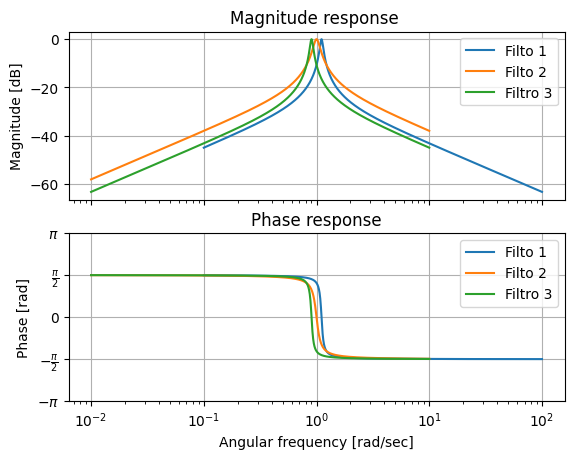

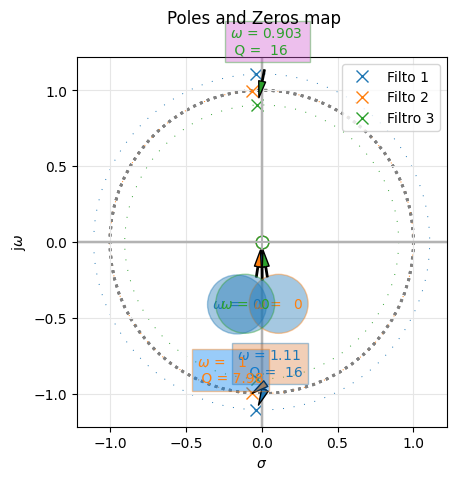

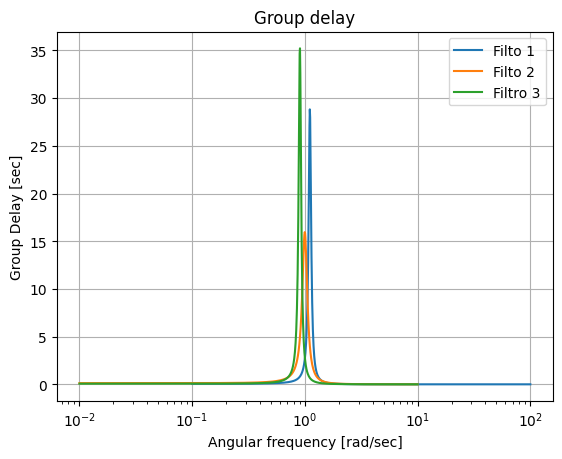

In [65]:

H2 = signal.TransferFunction( num1, den1 )
H3 = signal.TransferFunction( num2, den2 )
H4 = signal.TransferFunction( num3, den3 )
H = [H2,H3,H4]
analyze_sys(H,["Filto 1","Filto 2","Filtro 3"],same_figs=True)

A continuacion se muestran los valores obtenidos del filtro para cada uno de los paremetros calculados.

Transferencia en banda de paso:

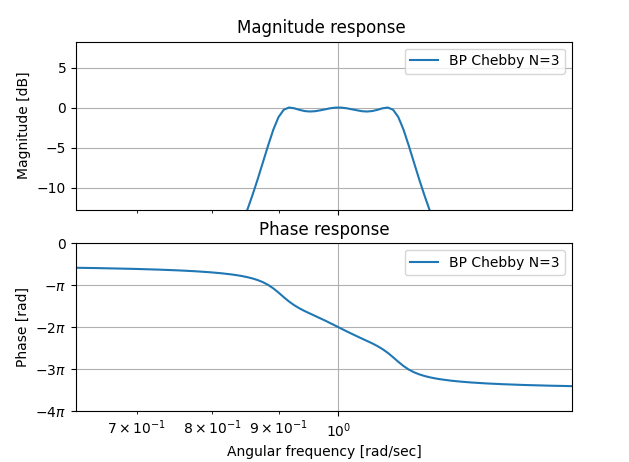

En esta imagen se observan las oscilaciones debido a que el filtro es de tipo Chebyshef

Se observa que la atenuacion maxima en esta banda es de 0.5db

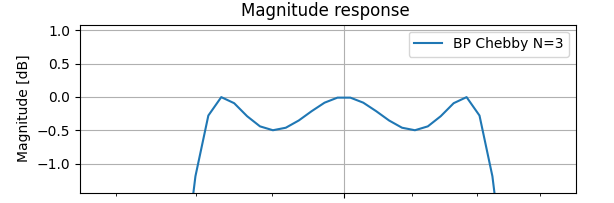

A continuacion se muestran las frecuencias de corte (Wp1 y Wp2).
Recordando que: Wp1_n=0.904 ; Wp2_n=1.1049 Y que la atenuacion maxima era de 0.5db

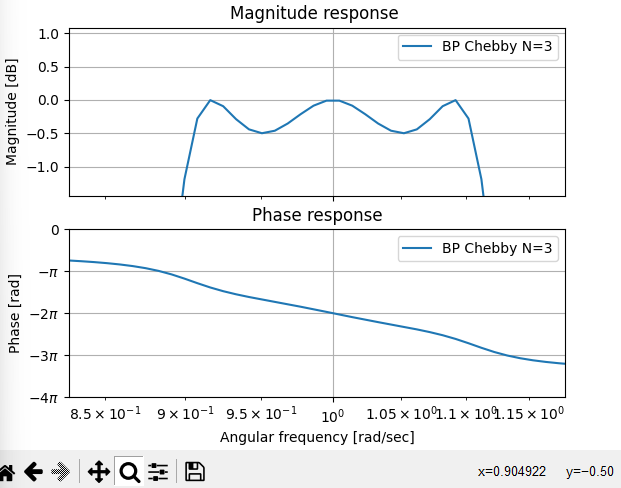

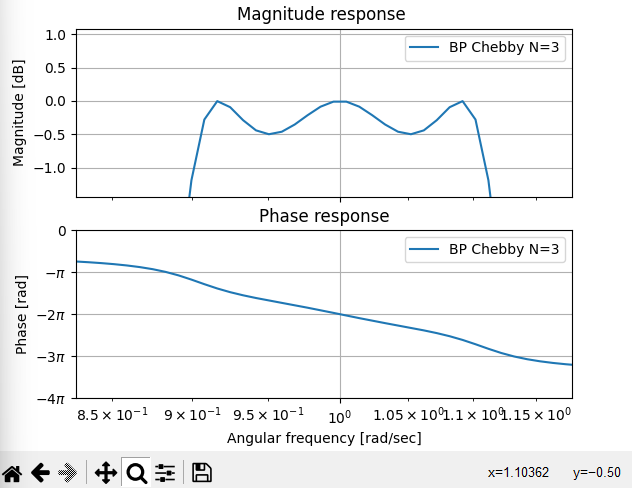

Ahora se analizan los punto de Ws1 y Ws2.
Recordando que: Ws1_n=0.772 ; Ws2_n=1.636 Y que la atenuacion minima era de -16dB y -24dB respectivamente.
NOTA: tener en cuenta que debido a que el orden que se tomo es N=3, la atenuacion en las bandas de stop sera aun mayor, siendo este el filtro mas eficiente para cumplir con la plantilla.
Recordemos que:
 * alpha_min=26.86737148112998 para un n=3

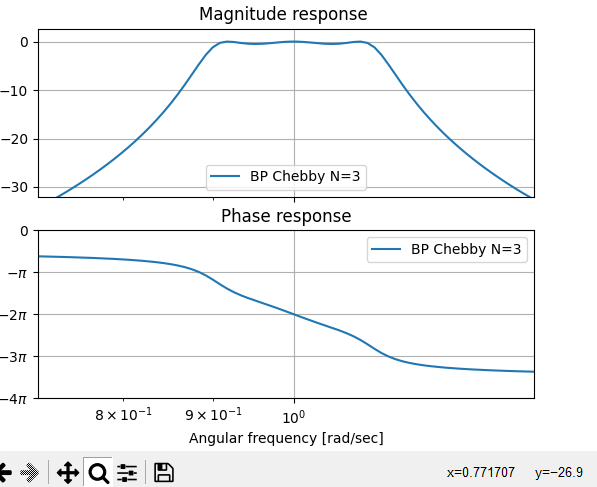

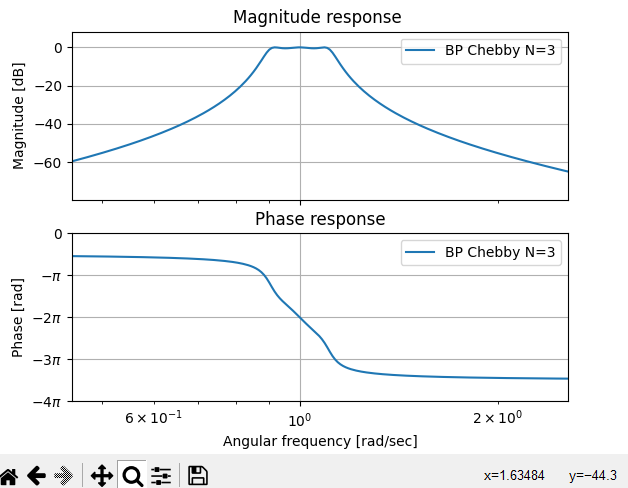

Al ser el filtro no simetrico vemos como la las atenuaciones para cada frecuencia especificada seran distintas. Sin embargo ambas cumplen con el reuquisito minimo del filtro
